## **0. Introduction**

This notebook continues the series of machine learning techniques with the goal to decode the brain activitiy given the respective categories. Unfortunately, neither the LogReg nor the SVM produced any results that back the initial hypothesis. Still, we will set up the Neuralnetwork for the purpose of learning the respective technique.

## **1.0 Loading the data**

In [1]:
import os
os.chdir("/home/jpauli/ds001506/sourcedata/sub-01/anat")

In [2]:
mask_img_path = '/home/jpauli/ds001506/sourcedata/sub-01/anat'
mask_img_L = os.path.join(mask_img_path,'sub-01_mask_LH_V1v.nii.gz')
mask_img_R = os.path.join(mask_img_path,'sub-01_mask_RH_LOC.nii.gz')

In [3]:
from nilearn.maskers import NiftiMasker
nifti_masker = NiftiMasker(mask_img=mask_img_L)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
X = []
Y = []
Sessions = []
category = 1
for session in ["1","2","3","4"]:
    os.chdir('/mnt/c/Users/janos/git/sessions_new/z_maps_{}'.format(session))
    for x in os.listdir():
        if x == 'nilearn_cache':
            continue
        else:
            X.append(nifti_masker.fit_transform(x))
            Y.append(category)
            Sessions.append(session)
            category=category+1
            if category == 27:
                category = 1

Y = np.array(Y)
df =  pd.DataFrame(np.concatenate(X))
X_ = df.to_numpy()

Rescaling, because PyTorch requires Y labels to range from 0 to 1.

In [5]:
y = Y-1
y

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25,  0,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25,  0,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25])

In [54]:
Y_unique = np.unique(y)
Y_unique

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

In [56]:
np.random.shuffle(Y)
y_train = []
y_test = []


for category in y:
        if len(y_test) == len(Y_unique):
            y_train.append(category)
        else:
            y_test.append(category)
            if y_test.count(category) > 1:
                y_test.remove(category)
                y_train.append(category)
                continue

In [57]:
y_test = np.array(y_test)
y_train = np.array(y_train)

In [58]:
len(y_test)

26

Split data

In [64]:
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
#X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2,random_state=42)
X_train, X_test = train_test_split(X_, test_size=0.25,random_state=42)

In [65]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

General imports of pytorch modules needed to define the network. NN stands for Neural Network and is part of the pytorch library.

In [8]:
import torch
from torch import nn
from torch import optim

Numpy arrays to pytorch tensor

In [66]:
X_tensor_train = torch.from_numpy(X_train)
Y_tensor_train = torch.from_numpy(y_train)
X_tensor_test = torch.from_numpy(X_test)
Y_tensor_test = torch.from_numpy(y_test)

In [67]:
X_tensor_train = torch.tensor(X_tensor_train,dtype = torch.float32)
Y_tensor_train = Y_tensor_train.type(torch.LongTensor)

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [69]:
X_tensor_test.shape

torch.Size([26, 992])

In [70]:
X_tensor_test = torch.tensor(X_tensor_test,dtype = torch.float32)
Y_tensor_test = Y_tensor_test.type(torch.LongTensor)

/home/jpauli/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


First things first, we should define our neural network by using pythons *classes* and more important, the pytorch nn.Module. Then, we initialize and determine the inputs: The class takes three arguments: Itself (so nn.Module), n inputs and n outputs, corresponding to our x and y data. 
We apply the super function in order to invoke the properties of the class.

Then we define our first variables: "self.in_layer" and "self.out_layer".
By using the linear function of the nn module, we define for the first variable, that it takes n inputs and n hidden layers. This is our input layer, so the information is forwarded from the n_input to n_hidden layers. The out_layer variable passed the input from the n_hidden layers to 26 output layers. 26 is chosen, because we want to predict 26 classes.

We go on by defining the forward method. The forward method runs when calling the class as a function. It takes the z_maps as an input and passes it through the hidden layer to produce the weights and to finally pass it to the output layer, in order to predict the respective category.

I definitely got a lot of help from the Neuromatch course on [computational neuroscience](https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W1D5_DeepLearning/student/W1D5_Tutorial1.ipynb#scrollTo=JFdPAcDx22RZ).

In [12]:
class DecodingReLuNN(nn.Module):
    def __init__(self,n_inputs,n_hidden):
        super().__init__()
        self.in_layer = nn.Linear(n_inputs,n_hidden)
        self.out_layer = nn.Linear(n_hidden, 26)
    def forward(self,V_P):
    #Decode category from voxel pattern

    #Args:
     # Voxel_pattern (torch.Tensor): vector of neural responses to decode, must be of
      #  length n_inputs. Can also be a tensor of shape n_stimuli x n_inputs,
       # containing n_stimuli vectors of neural responses

    #Returns:
    #torch.Tensor: network outputs for each input provided in Voxel_pattern. If
    #Voxel_pattern is a vector, then y is a 1D tensor of length 1. If Voxel_pattern is a 2D
    #tensor then y is a 2D tensor of shape n_stimuli x 1.
    
        V_P = torch.relu(self.in_layer(V_P))
        y = self.out_layer(V_P)
        return y

In [13]:
np.random.seed(1)
torch.manual_seed(1)

#Initialize a deep network with 10 hidden units
net = DecodingReLuNN(X_tensor_train.shape[1], 20)

# Get voxel pattern and predicted category for all stimuli
V_P, category = X_tensor_train, Y_tensor_train 

# Decode category from these neural responses using initialized network
out = net(V_P)  # compute output from network, equivalent to net.forward(r)
loss_fn = nn.CrossEntropyLoss()

# Evaluate Cross entropy loss
loss = loss_fn(out, category)
y_pred_probs = torch.softmax(out, dim=1) #get probability for given class
y_preds = y_pred_probs.argmax(dim=1)
print('true category: {}'.format(category))
print('Predicted category:{}'.format(y_preds))
print('cross entropy loss {}'.format(loss))

true category: tensor([ 3, 22, 24, 18, 20, 15, 16, 14,  9,  7, 11, 25,  0,  2,  1,  5, 10,  4,
        13,  9, 16, 14,  8,  7, 17, 16, 17,  1, 19,  6, 25, 21, 23, 13, 24,  3,
        17, 12,  8,  3,  6, 15, 10, 12,  5,  2, 24, 18, 20, 21,  9, 22, 18, 15,
         6, 22, 11,  5, 23,  6, 19,  7, 11, 23, 11,  3,  1,  0, 21,  2, 23,  9,
        16, 22,  8,  4, 20,  8, 19, 14, 14, 25, 24])
Predicted category:tensor([ 1, 22, 15,  4, 22, 22,  4,  4, 22,  1, 22, 24,  9,  4, 24, 22,  4, 15,
         4,  4, 22, 11,  4, 22,  4,  1,  1,  4, 22, 24, 22,  4,  4, 22, 22, 22,
        22,  4, 22, 24, 22, 15,  4,  1,  1, 11,  4,  1,  4,  1, 22, 24,  1, 22,
         1,  4, 24,  1, 11,  4, 24,  1,  4, 24,  4,  4, 22,  1, 22, 22, 22,  1,
        24,  1, 24, 24, 22,  1, 24, 22,  1,  4,  1])
cross entropy loss 3.2896008491516113


In [14]:
len(y_preds)

83

Optimization with gradient descent and regularization (weight_decay)

In [15]:
def train(net, loss_fn, train_data, train_labels,
          n_epochs=50, learning_rate=0.01):
    optimizer = optim.SGD(net.parameters(), lr=learning_rate,weight_decay=1e-4)
    train_loss = []
    net.train()
    for i in range(n_epochs):
        out = net(train_data)  # compute network output from inputs in train_data
        
        # Clear previous gradients
        optimizer.zero_grad()
        # evaluate loss function
        loss = loss_fn(out, train_labels)
        # Compute gradients
        loss.backward() 
        # Update weights
        optimizer.step()
        # Store current value of loss
        train_loss.append(loss.item()) # .item() needed to transform the tensor output of loss_fn to a scalar
        # Track progress
        if (i + 1) % (n_epochs // 5) == 0:
          print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')
    y_pred = torch.softmax(out,dim=1).argmax(dim=1)
    
    ##evaluating model
    net.eval()
    inputs,labels = X_tensor_test, Y_tensor_test
    outputs = net(inputs)
    test_loss = loss_fn(outputs,labels)
    y_pred_test = torch.softmax(outputs,dim=1).argmax(dim=1)
    return train_loss, y_pred, y_pred_test, test_loss

iteration 160/800 | loss: 2.170
iteration 320/800 | loss: 1.369
iteration 480/800 | loss: 0.743
iteration 640/800 | loss: 0.398
iteration 800/800 | loss: 0.233


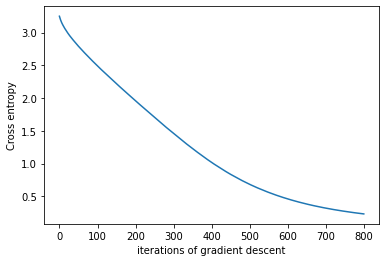

In [85]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

    # Initialize network with 50 hidden units
net = DecodingReLuNN(X_tensor_train.shape[1], 50)

    # Initialize built-in PyTorch Crossentrop loss function
loss_fn = nn.CrossEntropyLoss()

    # Run gradient descent on data
train_loss,y_pred,y_pred_test,test_loss = train(net,loss_fn,X_tensor_train,Y_tensor_train,
                                      n_epochs = 800,learning_rate=0.01)
  

    # Plot the training loss over iterations of GD
    
plt.plot(train_loss)

plt.xlabel('iterations of gradient descent')
plt.ylabel('Cross entropy')
plt.show()

<AxesSubplot:>

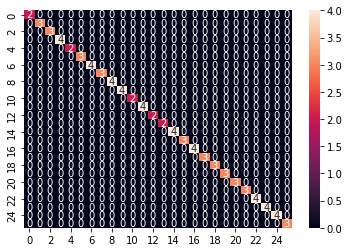

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix_train = confusion_matrix(Y_tensor_train, y_pred)

sns.heatmap(cf_matrix_train, annot = True)

In [79]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_tensor_train,y_pred)

1.0

<AxesSubplot:>

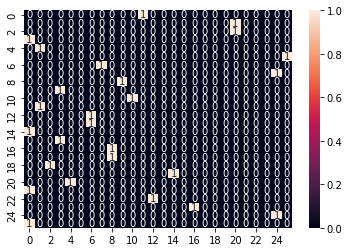

In [84]:
cf_matrix_test = confusion_matrix(Y_tensor_test, y_pred_test)

sns.heatmap(cf_matrix_test, annot = True)

In [86]:
accuracy_score(Y_tensor_test,y_pred_test)

0.038461538461538464

Not sure if I did all steps correct, but 0 accuracy is a nice replication!!!